# SQL Alchemy Homework (Week 10) – Surfs Up!

First, we need to start by importing some of the modules we will need later to complete this homework: `matplotlib`, `numpy`, `pandas`, and `datetime`.

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime, timedelta

## Reflect Tables into SQLAlchemy ORM

As a second step, we will reflect the tables in the `Resources/hawaii.sqlite` database into the SQLAlchemy ORM (Object Relational Mapper). To do that we start by importing the SQLAlchemy modules we need:

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

Now that the modules are imported, we need an engine connected to the database we want to reflect.

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

Once the engine is connected, we need to initialize a `Base` object using `automap_base` (instead of `declarative_base`).

In [6]:
Base = automap_base()

Using the `prepare` method on the `Base` object we just created, everything available in `engine` will be scanned and everything it can be reflected will be reflected. Version 1.0 of SQLAlchemy cannot reflect `CheckConstraints`, comments, or triggers.

In [7]:
Base.prepare(engine, reflect=True)

Reflection has created ORM objects for each table that is accessible under the `class` property of the automap `Base`. Let's list all those objects:

In [8]:
Base.classes.keys()

['measurement', 'station']

Let's create two objects, `Measurement` and `Station`, to reference the `measurement` and `station` tables.

In [9]:
Measurement = Base.classes.measurement
Station = Base.classes.station

Finally, we need to create a session. Session is the way SQLAlchemy ORM interacts with the database. It wraps a database connection via an engine, and provides an identity map for objects loaded via the session or associated with the session. The identity map is a cache-like data structure that contains a unique list of objects determined by the object's table and *primary key*. Sessions also wraps transactions which will stay open until the session is commited or rolled back.

In [10]:
session = Session(engine)

## Step 1 – Exploratory Climate Analysis

To start this analysis, we need to query the database and get the last 12 months of precipitation data. To do that we need to start by finding the date for the last data point. Where is the field that holds that date? To find out let's inspect tables and columns in the database first using SQLAlchemy `inspector`. 

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
# columns in `measurement` table
for column in inspector.get_columns('measurement'):
    print(f"{column['name']:>9} | {column['type']}")

       id | INTEGER
  station | TEXT
     date | TEXT
     prcp | FLOAT
     tobs | FLOAT


In [13]:
# columns in `station` table
for column in inspector.get_columns('station'):
    print(f"{column['name']:>9} | {column['type']}")

       id | INTEGER
  station | TEXT
     name | TEXT
 latitude | FLOAT
longitude | FLOAT
elevation | FLOAT


Now we know the field containing the date is in the `measurement` table, is called `date`, and is of type `Text`. We can find now the latest date using a simple query to our ORM. Note that what we get from executing the query is an object of type `sqlalchemy.util._collections.result`. To get the `string` value inside the object, we need to refer to index 0 of the returned object which is a list.

In [14]:
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
lastdate

'2017-08-23'

Since we need to get the last 12 months of data, we need to determine the date one year ago from the last date calculated in the previous cell. Initially, I considered using `timedelta` to calculate years but is not supported for some reason. I ended up using a third party module as documented in https://stackoverflow.com/questions/765797/python-timedelta-in-years. This case was simple but it might get complicated when the span of time is larger and includes leap years.

In [15]:
from dateutil.relativedelta import relativedelta

d = datetime.strptime(lastdate, '%Y-%m-%d') - relativedelta(years=1)
yearago = d.strftime('%Y-%m-%d')
yearago

'2016-08-23'

### Precipitation Analysis

With the dates we can now build a query to our ORM to get last 12 months of precipitation data.

In [16]:
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yearago).all()

Let's convert the results obtained into a Pandas DataFrame, set the index to the date column, and sort the DataFrame by date.

In [17]:
precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)
precipitation_df.sort_index(axis=0, inplace=True)
precipitation_df.dropna(inplace=True)
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


As you can see from the previous output, there are several values for the same date. This is because there are several stations collecting data. One of the methods to estimate areal precipitation is calculating the arithmetic mean of the measurements (https://www.weather.gov/abrfc/map). Let's do that using a `group by`.

In [18]:
groupby_date = precipitation_df.groupby('date')
df = groupby_date.mean()
df.sort_index(axis=0, inplace=True)
df.head(5)

,precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


Let's plot the DataFrame using Matplotlib.

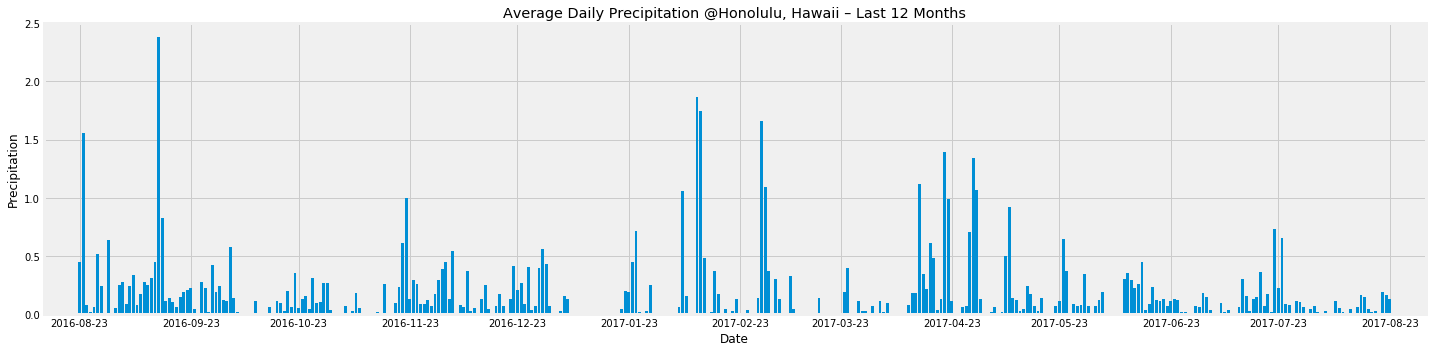

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(x=df.index, height=df['precipitation'])
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.set_xticks([0, 31, 61, 92, 122, 153, 184, 212, 243, 273, 304, 334, 365])  # set ticks every month
ax.set_xlim(-10,375)
ax.set_title('Average Daily Precipitation @Honolulu, Hawaii – Last 12 Months')
fig.tight_layout()
plt.show()
fig.savefig('Images/precipitation-plot.png')

We can use Pandas to calculate the summary statistics for the precipitation data.

In [20]:
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

Now let's do a query to show how many stations are available in this dataset.

In [21]:
session.query(func.count(Station.id)).first()

(9)

Next, let's find out which are the most active stations (i.e. which stations have the most rows).
We will list all the stations and the counts in descending order.

In [22]:
stations_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

Using the Station ID of the most active station identified in the previous cell, let's calculate lowest temperature recorded, highest temperature recorded, and average temperature recorded by that station.

In [23]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == stations_activity[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

Let's determine the station with the highest number of temperature observations.

In [24]:
stations_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_tobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

Now, let's query the last 12 months of temperature observation data for this station and plot the results as a histogram.

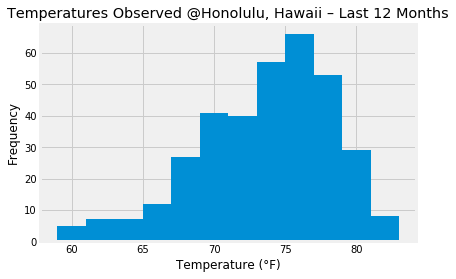

In [25]:
results = session.query(Measurement.tobs).\
    filter(Measurement.date >= yearago).\
    filter(Measurement.station == stations_tobs[0][0]).all()
tobs_df = pd.DataFrame(results, columns=['tobs'])
tobs_df
fig, ax = plt.subplots()
tobs_df.hist(column='tobs', bins=12, ax=ax, label='tobs')
ax.set_title('Temperatures Observed @Honolulu, Hawaii – Last 12 Months')
ax.set_xlabel('Temperature (°F)')
ax.set_ylabel('Frequency')
plt.show()
fig.savefig('Images/temperatures-hist.png')

## Step 2 – Climate App

Please refer to `climate_app.py` for this step.

## Optional: Other Recommended Analysis

Optional challenge queries.

### Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December? Let's find out.

First, let's get an average of all temperatures in June and December for all years across all the stations using SQLAlchemy ORM queries.

In [26]:
import pprint

avg_temp_jun = session.query(func.substr(Measurement.date, 1, 4).label('year'),\
              func.avg(Measurement.tobs).label('avg_temp')).\
              filter(func.substr(Measurement.date, 6, 2).label('month') == '06').\
              group_by(func.substr(Measurement.date, 1, 4)).all()
avg_temp_dec = session.query(func.substr(Measurement.date, 1, 4).label('year'),\
              func.avg(Measurement.tobs).label('avg_temp')).\
              filter(func.substr(Measurement.date, 6, 2).label('month') == '12').\
              group_by(func.substr(Measurement.date, 1, 4)).all()
pp = pprint.PrettyPrinter(indent=2)
print("June Data:")
pp.pprint(avg_temp_jun)
print()
print("December Data:")
pp.pprint(avg_temp_dec)

June Data:
[ ('2010', 74.92561983471074),
  ('2011', 73.93832599118943),
  ('2012', 74.0),
  ('2013', 74.59907834101382),
  ('2014', 75.02790697674419),
  ('2015', 74.99014778325123),
  ('2016', 75.17525773195877),
  ('2017', 77.21989528795811)]

December Data:
[ ('2010', 70.20851063829787),
  ('2011', 70.82062780269058),
  ('2012', 71.18807339449542),
  ('2013', 71.09401709401709),
  ('2014', 69.89686098654708),
  ('2015', 73.42391304347827),
  ('2016', 71.13)]


Now, let's apply a t-test for both datasets, June and December. Since we are not getting samples from the same population, since we are comparing different months, we should use an unpaired t-test (equal_var=False).

In [27]:
from scipy.stats import sem, ttest_ind

# unpack tuples with temperature data
avg_temp_jun_unpacked = list(zip(*avg_temp_jun))[1]
avg_temp_dec_unpacked = list(zip(*avg_temp_dec))[1]

# t-test
(t_stat, p) = ttest_ind(avg_temp_jun_unpacked, avg_temp_dec_unpacked, equal_var=False)

if p < 0.05:
    print(f"The differences between June and December temperatures are significant! (p={p})")
else:
    print(f"The differences between June and December temperatures are due to chance (p-{p}).")

The differences between June and December temperatures are significant! (p=1.4518830376438732e-05)


### Temperature Analysis II

Use the `calc_temps` function provided in the starter notebook to calculate minimum, average, and maximum temperature for the range of dates corresponding to my planned trip but for the previous year.

Below the `calc_temps` function provided in the starter Jupyter notebook.

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


Now let's use the `calc_temps` function provided to calculate minimum, average, and maximum temperature for my trip which is planned between July 1st and July 15th but for last available year (2017).

In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = '2017-07-01'
trip_end_date = '2017-07-15'
temps = calc_temps(trip_start_date, trip_end_date)[0]
print(temps)
temps_dict = {}
temps_dict['min'] = temps[0]
temps_dict['avg'] = temps[1]
temps_dict['max'] = temps[2]

(69.0, 78.25, 87.0)


Plot the min, avg, and max temperature from the previous query as a bar chart. Use the average temperature as the bar height. Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

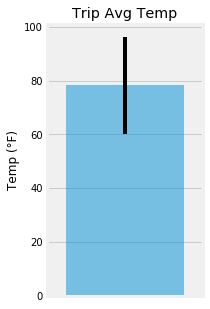

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(2.5, 5))
ax.bar(x=0.5, height=temps_dict['avg'], width=0.75, yerr=temps_dict['max']-temps_dict['min'], alpha=0.5)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (°F)')
ax.set_xticks((0, 1))
ax.set_xticklabels([])
ax.grid(b=False, which='both', axis='x')
plt.show()
fig.savefig('Images/temperatures-plot.png')

### Daily Rainfall Average

Calculate the total amount of rainfall per weather station for my trip dates using the previous year's matching dates. Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation. As mentioned before, my trip is planned between July 1st and July 15th.

In [31]:
from sqlalchemy import desc

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
results = session.query(*sel, func.sum(Measurement.prcp).label('prcp_amount')).\
            filter(Measurement.date >= trip_start_date).filter(Measurement.date <= trip_end_date).\
            filter(Measurement.station == Station.station).\
group_by(*sel).order_by(desc('prcp_amount')).all()
pp.pprint(results)

[ ( 'USC00516128',
    'MANOA LYON ARBO 785.2, HI US',
    21.3331,
    -157.8025,
    152.4,
    2.8700000000000006),
  ( 'USC00519281',
    'WAIHEE 837.5, HI US',
    21.45167,
    -157.84888999999998,
    32.9,
    1.6400000000000001),
  ( 'USC00513117',
    'KANEOHE 838.1, HI US',
    21.4234,
    -157.8015,
    14.6,
    0.8300000000000001),
  ( 'USC00514830',
    'KUALOA RANCH HEADQUARTERS 886.9, HI US',
    21.5213,
    -157.8374,
    7.0,
    0.39),
  ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21),
  ( 'USC00519523',
    'WAIMANALO EXPERIMENTAL FARM, HI US',
    21.33556,
    -157.71139,
    19.5,
    0.13),
  ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


This is the function provided in the starter notebook to calculate daily normals. We will use it in the next cells for the last optional challenge.

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

Create a list of `%m-%d` strings for each of my trip dates, so the `daily_normals` function can be used.

In [33]:
start = datetime.strptime(trip_start_date, "%Y-%m-%d")
end   = datetime.strptime(trip_end_date,   "%Y-%m-%d")
date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days+1)]
date_generated

dates = [date.strftime('%m-%d') for date in date_generated]
dates

['07-01',
 '07-02',
 '07-03',
 '07-04',
 '07-05',
 '07-06',
 '07-07',
 '07-08',
 '07-09',
 '07-10',
 '07-11',
 '07-12',
 '07-13',
 '07-14',
 '07-15']

Calculate the normals for each day using the list created in the previous step.

In [34]:
trip_normals = [daily_normals(date) for date in dates]
trip_normals

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0)]

Load the previous query results into a Pandas DataFrame and add tge `trip dates` as the `date` index.

In [35]:
df = pd.DataFrame(trip_normals, columns=['tmin', 'tavg', 'tmax'])
df.set_index(pd.Series(dates), inplace=True)
df.index.names = ['date']
df

,tmin,tavg,tmax
date,,,
07-01,67.0,74.777778,81.0
07-02,68.0,75.403846,82.0
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0


Use Pandas to plot an area plot (stacked=False) for the daily normals.

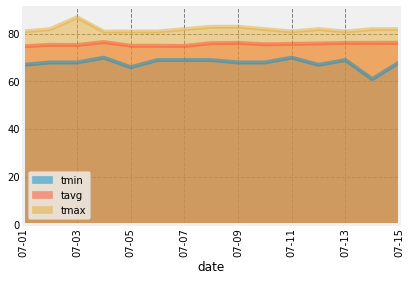

In [36]:
fig, ax = plt.subplots()
df.plot.area(stacked=False, ax=ax)
ax.grid(b=True, which='major', color='grey', linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.savefig('Images/rainfall-plot.png')